**Libraries**

In [1]:
# Import necessary libraries
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

**Transform**

In [2]:
# Define data transformations for training and testing datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

**Loading Data**

In [3]:
# Set up data directories
data_dir = 'C:/Users/LEGION/Downloads/Adıyaman-AD1 (Turkish side)-20240717T161401Z-001/Adıyaman-AD1 (Turkish side)/dataset/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

**Initialize VGG-19**

In [4]:
# Load the pretrained VGG19 model and modify the classifier
model_ft = models.vgg19(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, len(class_names))

# Set up device, loss function, and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

c:\Users\LEGION\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\LEGION\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Train**

In [5]:
# Initialize variables for tracking losses and accuracies
losses = {'train': [], 'test': []}
accuracies = {'train': [], 'test': []}

# Train the model
num_epochs = 10
best_model_wts = copy.deepcopy(model_ft.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)
    
    for phase in ['train', 'test']:
        if phase == 'train':
            model_ft.train()  # Set model to training mode
        else:
            model_ft.eval()   # Set model to evaluation mode

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model_ft(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        losses[phase].append(epoch_loss)
        accuracies[phase].append(epoch_acc.cpu().numpy())  # Move to CPU and convert to NumPy

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'test' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model_ft.state_dict())

print(f'Best test Acc: {best_acc:.4f}')


Epoch 0/9
----------
train Loss: 1.0963 Acc: 0.3333
test Loss: 0.9056 Acc: 0.8333
Epoch 1/9
----------
train Loss: 1.0254 Acc: 0.4815
test Loss: 0.8500 Acc: 0.6667
Epoch 2/9
----------
train Loss: 0.8460 Acc: 0.7037
test Loss: 0.8296 Acc: 0.5000
Epoch 3/9
----------
train Loss: 0.8217 Acc: 0.6667
test Loss: 0.8367 Acc: 0.5000
Epoch 4/9
----------
train Loss: 0.7638 Acc: 0.6667
test Loss: 0.8420 Acc: 0.5000
Epoch 5/9
----------
train Loss: 0.7169 Acc: 0.6667
test Loss: 0.8240 Acc: 0.5000
Epoch 6/9
----------
train Loss: 0.6432 Acc: 0.6667
test Loss: 0.7816 Acc: 0.5000
Epoch 7/9
----------
train Loss: 0.6159 Acc: 0.7037
test Loss: 0.7256 Acc: 0.5000
Epoch 8/9
----------
train Loss: 0.5229 Acc: 0.7407
test Loss: 0.6825 Acc: 0.6667
Epoch 9/9
----------
train Loss: 0.4141 Acc: 0.8148
test Loss: 0.6556 Acc: 0.8333
Best test Acc: 0.8333


**Model Saving**

In [6]:
# Load the best model weights
model_ft.load_state_dict(best_model_wts)
torch.save(model_ft.state_dict(), 'best_vgg19_model_son_son.pth')

**Grad-CAM**

In [7]:
# Define Grad-CAM implementation
def grad_cam(input_image, model, target_layer_names, class_idx=None):
    model.eval()
    features_blobs = []
    gradients = []

    def hook_feature(module, input, output):
        features_blobs.append(output.cpu().data.numpy())
    
    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0].cpu().data.numpy())
    
    model._modules.get(target_layer_names).register_forward_hook(hook_feature)
    model._modules.get(target_layer_names).register_backward_hook(backward_hook)
    
    output = model(input_image)
    if class_idx is None:
        class_idx = np.argmax(output.cpu().data.numpy())
    
    one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
    one_hot[0][class_idx] = 1
    one_hot = torch.from_numpy(one_hot).to(device).requires_grad_(True)
    one_hot = torch.sum(one_hot * output)
    model.zero_grad()
    one_hot.backward(retain_graph=True)

    grads_val = gradients[0]
    target = features_blobs[0]
    weights = np.mean(grads_val, axis=(2, 3))[0, :]
    cam = np.zeros(target.shape[2:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * target[0, i, :, :]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    return cam

Predicted class: damage_type_c
True class: damage_type_c


c:\Users\LEGION\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


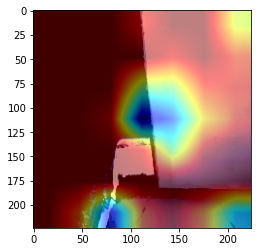

Predicted class: damage_type_c
True class: damage_type_c


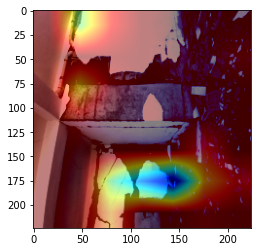

Predicted class: damage_type_a
True class: damage_type_a


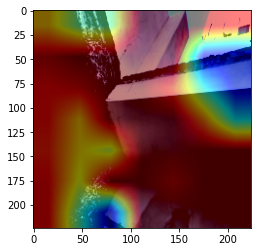

Predicted class: damage_type_a
True class: damage_type_a


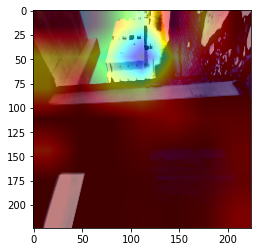

Predicted class: damage_type_a
True class: damage_type_b


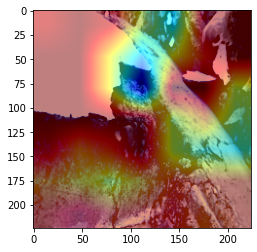

Predicted class: damage_type_a
True class: damage_type_a


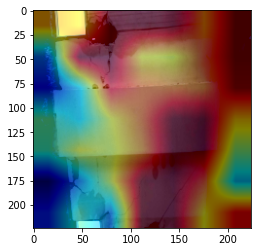

In [8]:
# Example of using Grad-CAM on test images
model_ft.eval()
inputs, classes = next(iter(dataloaders['test']))
inputs = inputs.to(device)
outputs = model_ft(inputs)
_, preds = torch.max(outputs, 1)

for i in range(len(inputs)):
    input_img = inputs[i].unsqueeze(0)
    cam = grad_cam(input_img, model_ft, 'features', class_idx=preds[i])
    
    # Display the image and Grad-CAM
    img = input_img.cpu().data.numpy().squeeze().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam_img = heatmap + np.float32(img)
    cam_img = cam_img / np.max(cam_img)
    
    print(f'Predicted class: {class_names[preds[i]]}')
    print(f'True class: {class_names[classes[i]]}')
    
    plt.imshow(cam_img)
    plt.show()

**Loss and Accuracy**

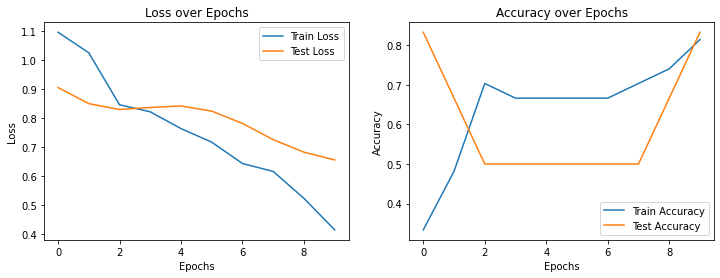

In [9]:
# Plotting losses and accuracies
epochs = range(num_epochs)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, losses['train'], label='Train Loss')
plt.plot(epochs, losses['test'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies['train'], label='Train Accuracy')
plt.plot(epochs, accuracies['test'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

**Confussion Matrix**

Total number of test samples: 6


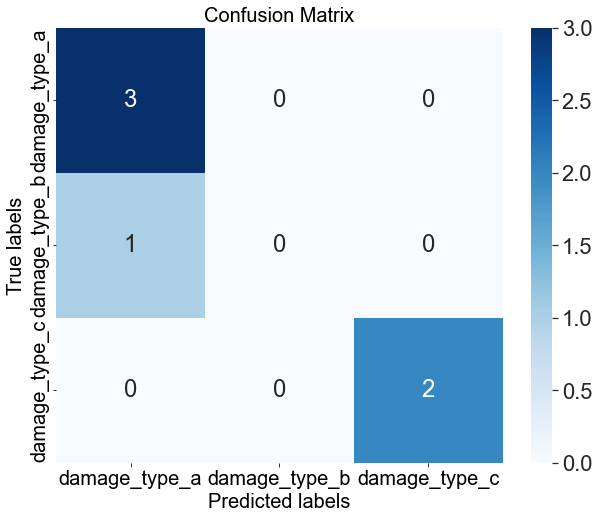

In [10]:
import seaborn as sns

# Collecting true labels and predictions
model_ft.eval()
y_test = []
y_pred = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        y_test.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Ensure all test samples are collected
print(f'Total number of test samples: {len(y_test)}')

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", ax=ax)

# Labels, title, and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(class_names, fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize=20)
plt.show()


In [11]:
y_pred

[0, 0, 2, 0, 0, 2]

In [14]:
y_test

[0, 0, 2, 1, 0, 2]